# Implement antisymmetric extension for higher convergence

- Grid: $0, \Delta x, ..., \Delta x \cdot (N - 1)$
- Set even derivatives at $x_0=0$ and $x_1 = \Delta x * ( N - 1)$ to $0$
- Uneven derivatives are given by $f^{(1)}(x_0), f^{(1)}(x_1), f^{(3)}(x_0), f^{(3)}(x_1), $...
- Define antisymmetric extension as {$f(x_0), ..., f(x_1), -f(x_1 - \Delta x), ..., -f(x_0 + \Delta x)$}

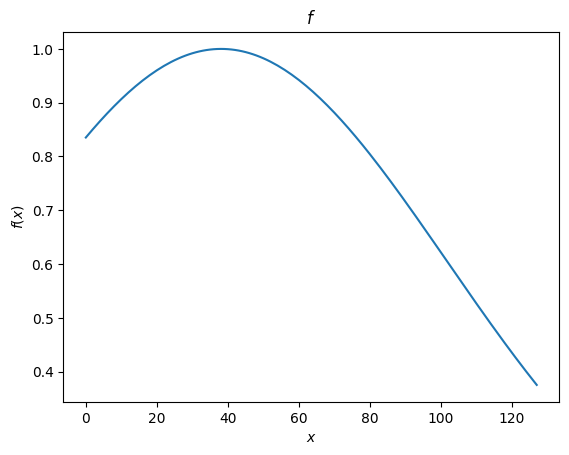

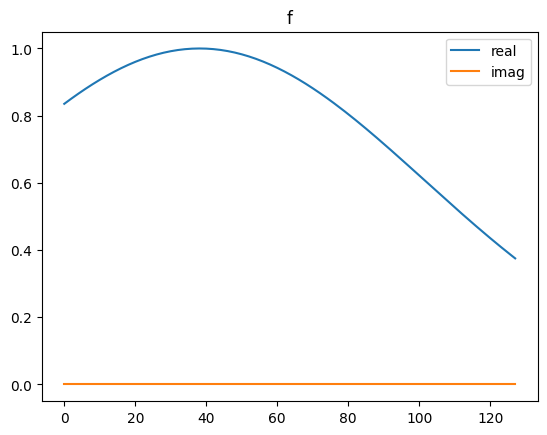

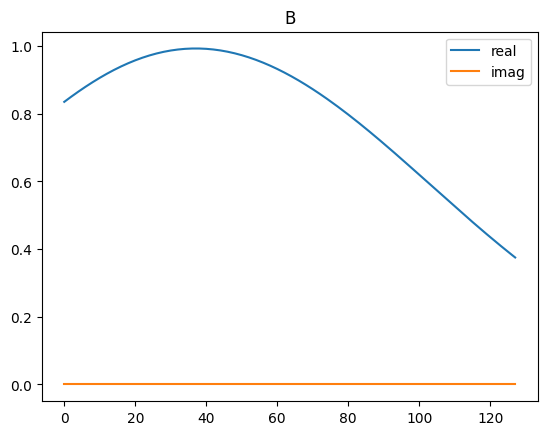

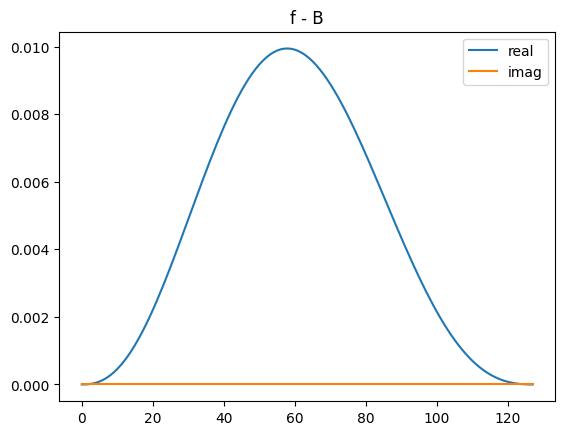

f[lb] = 0.835270211411272 f[rb] = 0.37531109885139957 B[0][lb] = 0.8352702114112722  B[0][rb] = 0.37531109885139957 homf[lb] = -2.220446049250313e-16 homf[rb] = 0.0


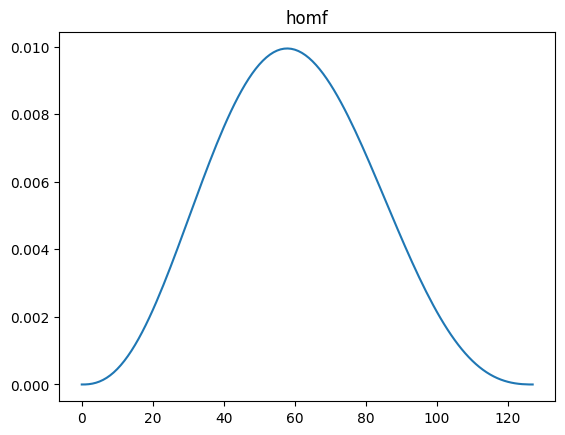

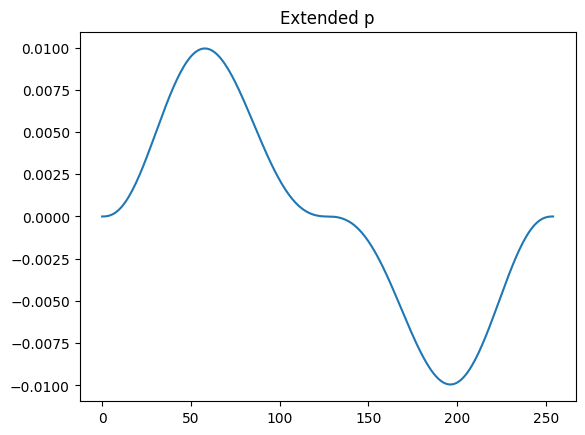

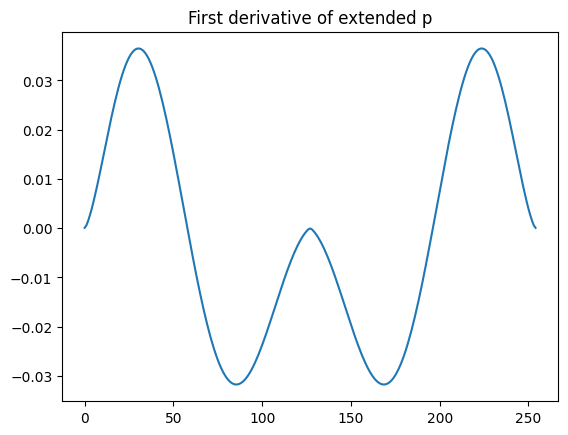

The extended p:  [-2.22044605e-16  1.14930351e-06  9.10811851e-06  2.53643489e-05
  5.12120139e-05  8.77597041e-05  1.35939003e-04  1.96512864e-04
  2.70083941e-04  3.57102851e-04  4.57876378e-04  5.72575590e-04
  7.01243879e-04  8.43804906e-04  1.00007044e-03  1.16974809e-03
  1.35244891e-03  1.54769493e-03  1.75492645e-03  1.97350931e-03
  2.20274193e-03  2.44186223e-03  2.69005440e-03  2.94645545e-03
  3.21016168e-03  3.48023484e-03  3.75570826e-03  4.03559264e-03
  4.31888172e-03  4.60455779e-03  4.89159690e-03  5.17897390e-03
  5.46566732e-03  5.75066396e-03  6.03296328e-03  6.31158159e-03
  6.58555604e-03  6.85394829e-03  7.11584803e-03  7.37037629e-03
  7.61668846e-03  7.85397709e-03  8.08147453e-03  8.29845524e-03
  8.50423795e-03  8.69818756e-03  8.87971685e-03  9.04828791e-03
  9.20341338e-03  9.34465753e-03  9.47163701e-03  9.58402149e-03
  9.68153406e-03  9.76395140e-03  9.83110383e-03  9.88287505e-03
  9.91920183e-03  9.94007342e-03  9.94553081e-03  9.93566585e-03
  9.9106

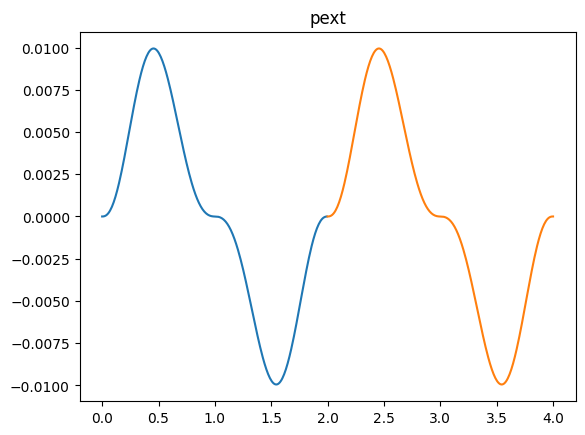

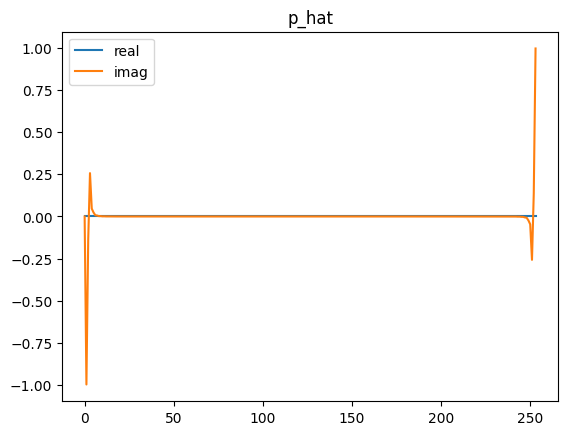

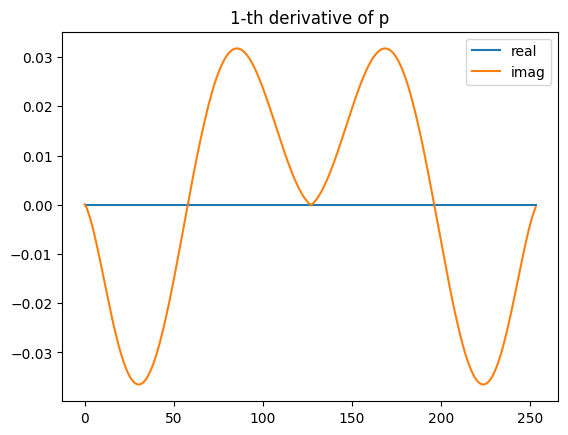

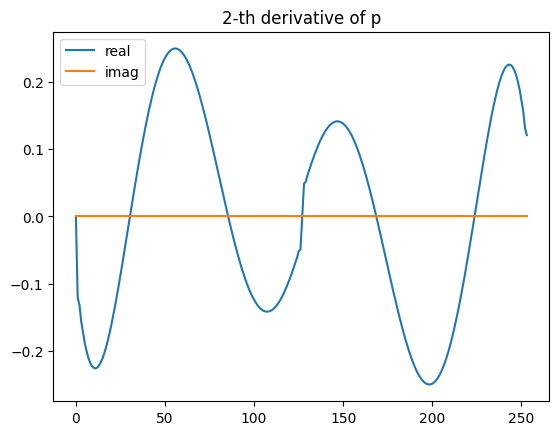

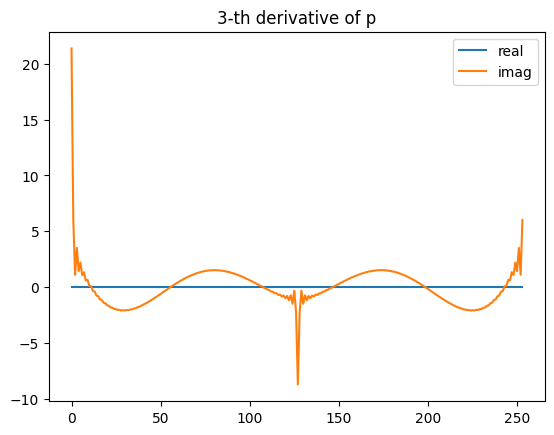

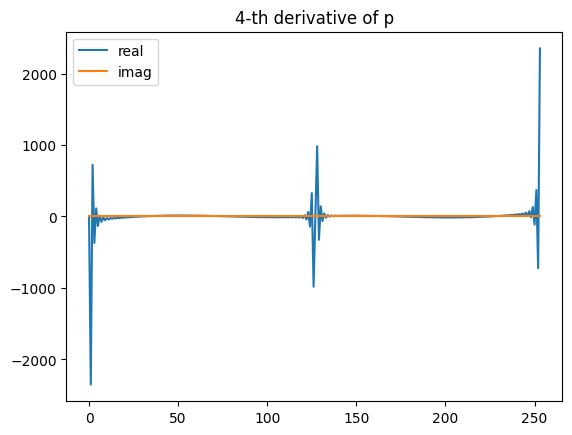

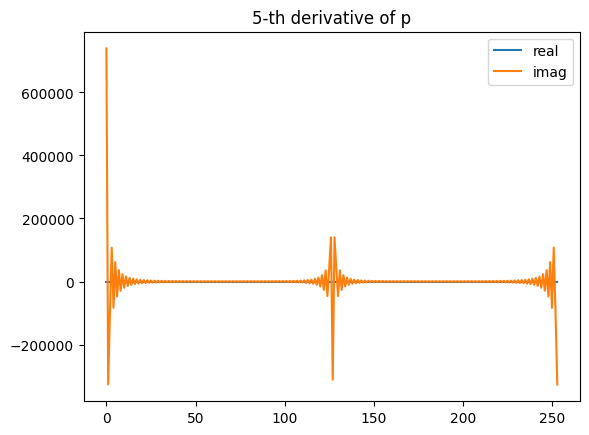

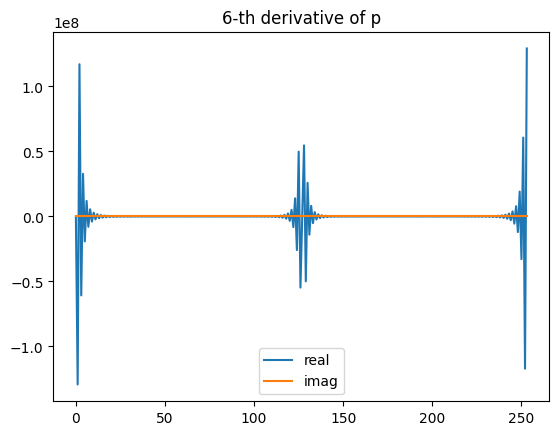

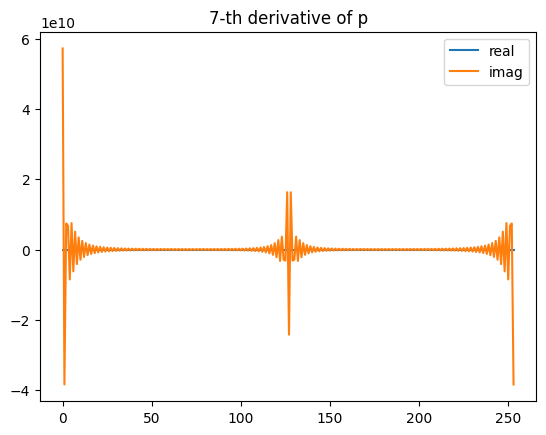

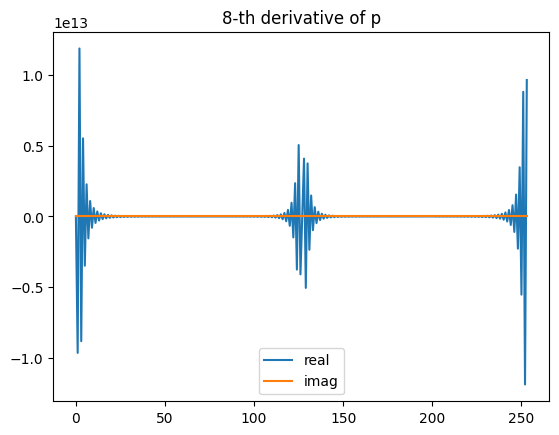

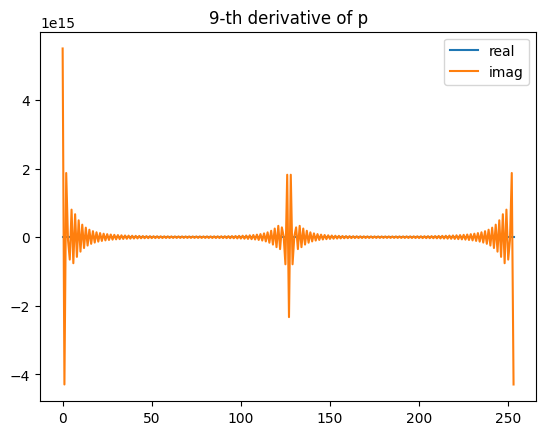

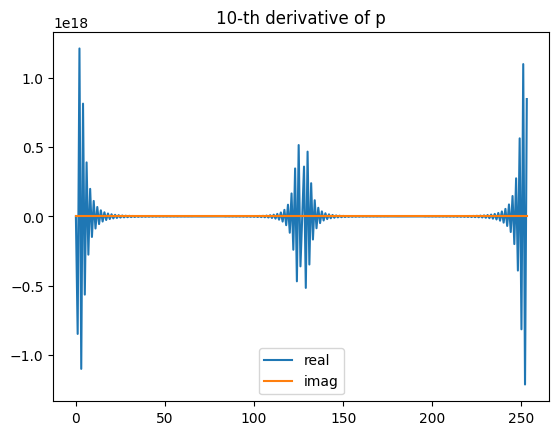

/home/calab912/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


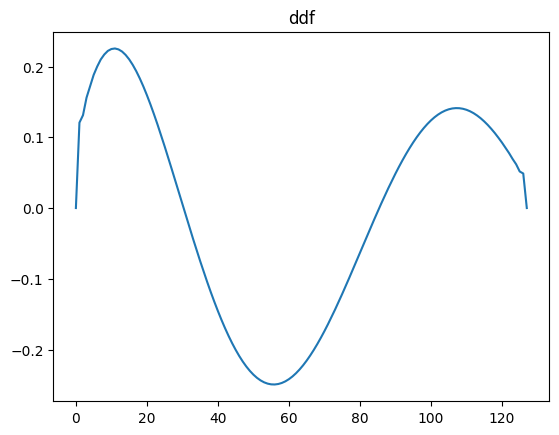

/tmp/ipykernel_139504/1849803864.py:117: ComplexWarning: Casting complex values to real discards the imaginary part
  f  [ lind : rind ]  = fp


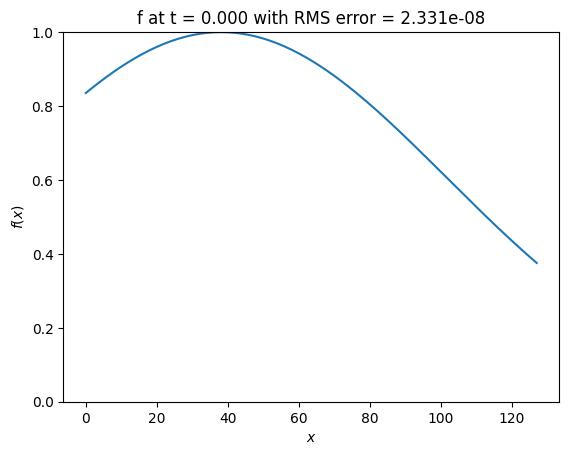

In [40]:
import spectral_derivative as sd
import numpy as np 
import matplotlib.pyplot as plt
import scipy 

L                 = 1
N                 = 128
dx                = L/(N - 1)
x                 = np.arange(0, N) * dx
dt                = 1e-4
v                 = 1
t                 = 0.0
tend              = 1.0
r                 = (v * dt)**2
ghostBoundary     = 6
fdl               = 0
fdr               = 0
BC                = sd.PERIODIC
mode              = sd.M_POLYNOMIAL
derivativeMode    = sd.ONE_SIDED
smoothingOrder    = 2
a, b              = 0, L
xgegenbauer       = (x - (a + b)/2)/ ((b - a)/2)

def func(x, v, t):
    return np.exp(-(x-0.3 - t * v)**2/0.5)

f  = func(x, v, t    )
fm = func(x, v, t - dt)

plt.title(r"$f$")
plt.plot(f)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()

#while t < tend:
if 1:
    #Fill ghost zone of length ghost boundary with boundary conditions
    for i in range(ghostBoundary + 1): 
        f[     i] = func(     i * dx, v, t)
        f[-1 - i] = func( L - i * dx, v, t)

    #Create shift function that such that f - B fulfills either Dirichlet, Neumann or periodic boundary conditions depending on mode
    B, poly = sd.getShiftFunction(x, f, mode, derivativeMode, lb = fdl, rb = fdr, N = smoothingOrder, debug= True)

    #Boundary for finite difference stencil
    lind =          fdl
    rind = len(x) - fdr 
    
    #Subtract linear shift function to enforce Dirichlet BC when computing second derivative
    homf            = f[ lind : rind ] - B[0]

    plt.title("homf") 
    plt.plot(homf) 
    plt.show() 

    pext           = np.concatenate([homf, -np.flip(homf)[1:]])
    xext           = np.concatenate([x, x[1:] + L])

    plt.title("Extended p") 
    plt.plot(pext)
    plt.show() 

    plt.title("First derivative of extended p") 
    plt.plot((np.roll(pext, -1) - np.roll(pext, 1))/(2*dx))
    plt.show()

    print("The extended p: ", pext)
    print(pext[1] - pext[0], pext[-1] - pext[-2])

    plt.title("pext") 
    plt.plot(xext[:-1], pext[:-1]) 
    plt.plot(xext + 2*L, pext) 
    plt.show() 

    pext, ind1, ind2   = sd.selectBC       (pext, BC)
    T1 = sd.DFT1
    p = pext

    k = sd.computeK(p, dx, T1)

    if len(p) % 2 != 0:
        raise ValueError("Fourier transform does not work well for an uneven number of grid points")
    
    p_hat = scipy.fft.fft(p)

    if 1:
        plt.title("p_hat")
        plt.plot(p_hat.real, label="real")
        plt.plot(p_hat.imag, label="imag")
        plt.legend()
        plt.show()

        for i in range(1, 11):
            plt.title(f"{i}-th derivative of p")

            dip = scipy.fft.ifft(p_hat * k**i)

            plt.plot(dip.real, label="real")
            plt.plot(dip.imag, label="imag")
            plt.legend()
            plt.show()



    p_hat = p_hat * (-1) * k**2

    ddf = scipy.fft.ifft(p_hat)

    ddf = ddf[:len(homf)]
    plt.title("ddf") 
    plt.plot(ddf) 
    plt.show() 
    fp                  = 2 * f [ lind : rind ] - fm [ lind : rind ] + r * ddf
    fm [ lind : rind ]  = f [ lind : rind ]
    f  [ lind : rind ]  = fp
    t += dt 

plt.title(f"f at t = {t:3.3f} with RMS error = {np.mean(np.abs(f - func(x, v, t))):3.3e}")
plt.plot(f)
plt.ylim([0, 1])
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()